## Feature Sign Search Algorithm - Assignment 1

## Author - Ankit Gupta


In [1]:
import numpy as np

#Function to implement the Feature-sign search Algorithm
#As explained in the paper this function with solve the follwing L1 optimization problem
#  min-x f(x) = ||y - Ax||^2 + gamma||x||1
#  y is the signal which we want to decompose; A is the dictionary; gamma is the sparcity
#  no_of_dispnts is number of discrete points in Line Search, approximate_zero is the Zero approximation

def myfeature_sign_search(A,y,gamma,no_of_dispnts = 100,approximate_zero = 1e-9):
    
    print("Starting Feature Search Algorithm with Zero Approximate ",approximate_zero)
    #Extract the size of given basis matrix, y vector and check the compatibility
    (k,n)   = A.shape; # k x n Matrix
    (y_dim,) = y.shape; # Vector of y_dim dimenssion
    
    assert k == y_dim 
    
    #House keeping tasks
    A_symmetric = np.dot(A.T,A)
    A_transpose = A.T
    Y = np.reshape(y,(y_dim,1))
    
    #Initilization Step 
    x = np.zeros((n,1),dtype = float) # All coefficients to Zero
#    x = np.array([[0],[0],[1]],dtype = float)
    theta = np.zeros((n,1)) # All sign values to Zero {-1,0,1} 
    active_set = np.array([],dtype = int)
    
    reiterate_step2 = 1
    
    #Step 2, reiterate till the optimality condition b is satisfied
    while reiterate_step2 == 1:
        #Calculate the Gradient of OLS cost function for zero coefficients
        grad_ols_cost = -2*np.dot(A_transpose,Y) + 2*np.dot(A_symmetric,x)
#       print("Start of Step 2, OLS cost ", grad_ols_cost)
        grad_ols_cost[x!=0] = 0 #Remove the gradient for non-zero coefficents
        max_arg = np.argmax(np.abs(grad_ols_cost))
        
        #Activate index if xi it satisfies the gamma condition
        if grad_ols_cost[max_arg] > gamma :
            theta[max_arg] = -1
            active_set = np.append(active_set,max_arg)
        
        if grad_ols_cost[max_arg] < -gamma :
            theta[max_arg] = 1
            active_set = np.append(active_set,max_arg)
    
#        print("Theta :", theta)
#        print("Active set :", active_set)
        
        active_set = np.array(sorted(active_set))
        
        reiterate_step3 = 1
        
        #Step 3, Feature-sign step
        while reiterate_step3 == 1 :    
            #Extract the A_hat, x_hat and theta_hat corresponding to the active set
            A_hat = A[:,active_set]    
            x_hat = x[active_set]
            theta_hat = theta[active_set]
#            print("A_hat", A_hat)
#            print("x_hat", x_hat)
#            print("theta_hat", theta_hat)
            
            #Analyticial Solution for the unconstrained QP
            A_hat_sym     = np.dot(A_hat.T,A_hat)
            A_hat_sym_inv = np.linalg.pinv(A_hat_sym) #This will provide more stable solution
            A_hat_y_gamma = np.dot(A_hat.T,Y) - 0.5*gamma*theta_hat
            x_hat_new     = np.dot(A_hat_sym_inv,A_hat_y_gamma)
#            print("A_hat_sym_inv", A_hat_sym_inv)
#            print("A_hat_y_gamma", A_hat_y_gamma)
#            print("x_hat_new", x_hat_new)
        
            #Discrete line search between x_hat and x_hat_new
            Obj_Val_min = np.linalg.norm((Y - np.dot(A_hat,x_hat_new)))**2 + gamma*np.dot(theta_hat.T,x_hat_new)
            x_hat_min  = x_hat_new
            x_hat_last = x_hat_new
            
            
            #check for co-efficient sign change
            for i in range(no_of_dispnts):
                x_hat_inter = x_hat_new + ((i + 1)/no_of_dispnts) * (x_hat - x_hat_new)
                x_hat_inter_sign = np.sign(x_hat_inter)
                x_hat_last_sign = np.sign(x_hat_last)
                sign_change = np.sum(x_hat_inter_sign - x_hat_last_sign)
                #sign change decision
                if sign_change != 0 :
                    #Calculate the new Objctive Value
                    Obj_Val_inter = np.linalg.norm((Y - np.dot(A_hat,x_hat_inter)))**2 + gamma*np.dot(theta_hat.T,x_hat_inter)
                    if Obj_Val_inter < Obj_Val_min :
                        Obj_Val_min = Obj_Val_inter
                        x_hat_min = x_hat_inter
                
                x_hat_last = x_hat_inter;
        
            #Updte x_hat  and x 
            x_hat = x_hat_min
            
            x_hat_index = 0
            for index in active_set:
                x[index] = x_hat[x_hat_index]
#                print("x_hat @ " , index , "is :", x_hat[x_hat_index])
                x_hat_index += 1
                
            #identify x_hat with zero coefficients, remove from active set, update theta
            zero_coefficient = (x_hat != 0)
            active_set = active_set[np.reshape(zero_coefficient,(zero_coefficient.shape[0],))]
            theta = np.sign(x)
            
#            print("Updated x_hat", x_hat)
#            print("Updated x", x)
#            print("updated Theta ", theta)
#            print("Zero Coefficient", zero_coefficient)
#            print("updated Active Set ", active_set)
                
            #Step 4a, Check the optimality condition for non-zero coefficients
            optimality_cost_temp = -2*np.dot(A_transpose,Y) + 2*np.dot(A_symmetric,x) + gamma * theta
            optimality_cost = optimality_cost_temp[x != 0]
            
            #Zero is not exactly captured, hence we have to put a limit to the Zero
            
            if abs(sum(optimality_cost)) <= approximate_zero :
                reiterate_step3 = 0
            else :
                reiterate_step3 = 1
            
#            print("In Step 3")
#            print("Optimality Cost type", optimality_cost_temp.dtype)
#            print("Optimality Cost all x for 4a:", optimality_cost_temp)
#            print("Sum of Optimality Cost non-zero x :", sum(optimality_cost))
            
         
        #Step 4b, Check the optimality condition for zero coefficients
        optimality_cost_temp_b = -2*np.dot(A_transpose,Y) + 2*np.dot(A_symmetric,x)       
        optimality_cost_b = np.abs(optimality_cost_temp_b[x == 0])
        
#        print("In Step 4")
#        print("Optimality Cost all x for 4b:", optimality_cost_temp_b)
#        print("Optimality Cost Zero x:", optimality_cost_b)
        
        #Check array size for iteration, if zero means all the coefficients are done
        array_size = optimality_cost_b.size;
        
        if array_size != 0:
            for i_cost in optimality_cost_b:
                if i_cost <= gamma:
                    reiterate_step2 = 0
                else : # End of Algorithm
                    reiterate_step2 = 1
        else:
            reiterate_step2 = 0
        
    print ("Feature Search Done")
        
    return  x

In [2]:
#Code to the the function by injecting
#Test data set with no noise
# y = 2*x + 3

A     = np.array([[1,1],[2,1],[3,1],[4,1],[5,1],[6,1],[7,1],[8,1],[9,1],[10,1]])
y     = np.array([5,7,9,11,13,15,17,19,21,23])
gamma = 0

print (myfeature_sign_search(A,y,gamma));



Starting Feature Search Algorithm with Zero Approximate  1e-09
Feature Search Done
[[2.]
 [3.]]


In [3]:
#Code to the function with a given univariate data set. TV units vs Sales
#Linear Regression Example
import pandas as pd

read_data = pd.read_csv('tvmarketing.csv')
tv_unit = read_data['TV'].values
ones = np.ones((tv_unit.shape[0],))
A_transpose = np.concatenate(([tv_unit],[ones]));
A = A_transpose.T
sales_unit = read_data['Sales'].values
y = np.array(sales_unit)
gamma = 10

#Graph Plotting to visualize the data points
import matplotlib.pyplot as plt

plt.scatter(tv_unit, sales_unit)
plt.show()

Starting Feature Search Algorithm with Zero Approximate  1e-09
Feature Search Done
Coefficients output from Algorithm:  [[0.04803446]
 [6.93439279]]


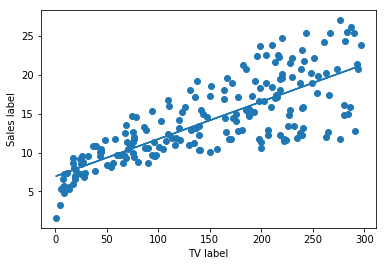

In [4]:
coefficients = myfeature_sign_search(A,y,gamma);
    
print("Coefficients output from Algorithm: ", coefficients);

sales_unit_hat = coefficients[0] * tv_unit + coefficients[1]

# Plot the points using matplotlib
plt.scatter(tv_unit, sales_unit)
plt.plot(tv_unit, sales_unit_hat)
plt.xlabel('TV label')
plt.ylabel('Sales label')
plt.show()